# Bernoulli attractor

In [2]:
using PyPlot, BernoulliMap, SoftPosit, LogFixPoint16s, StochasticRounding
using Statistics, StatsBase

And the Hofbauer invariant measure (Eq. 1 in Boghosian, Coveney and Wang, 2019)

$\quad h_\beta(x) = C\sum_{j=0}^\infty \beta^{-j} \theta(1_j - x)$

with $C$ a normalization constant, $\theta$ the Heaviside function and $1_j = f_\beta^j(1)$.

In [5]:
# Hofbauer invariant measure h with C=1
heaviside(x::AbstractFloat) = ifelse(x < 0, zero(x), ifelse(x > 0, one(x), oftype(x,0.5)))
h(x,β,N=100) = heaviside(1-x) + [β^-j for j in 1:N]'*heaviside.(bernoulli_map(1e0,β,N)[2:end] .- x)

h (generic function with 2 methods)

In [6]:
x2 = collect(0:1e-3:1)
βs2 = collect(1:1e-3:2)
nx,nβs = length(x2),length(βs2)
nsample = 1000

# create a matrix of βs
ββ = fill(0.0,nsample,nβs)
for i in 1:nβs
    ββ[:,i] .= βs2[i]
end

# formats
formats = [Posit32,Float32sr,Float64,Float16,Float16sr,Float32,LogFixPoint16,BFloat16sr]
Nformats = length(formats)

# sample analytical & numerical x
nens = 10
nsteps = 2000
nspinup = 1000
xβsample = fill(0.0,nsample,nβs)
xβFsample = fill(0.0,Nformats,nsample,nβs)

for (iβ,β) in enumerate(βs2) 
    # analytical
    aw = aweights(h.(x2,β))
    xsample = sample(x2,aw,nsample)
    xβsample[:,iβ] = xsample
    
    for (iformat,format) in enumerate(formats)
        X = fill(zero(format),nens,nsample÷nens)
        for i in 1:nens
            # sample random steps from bernoulli map, similar to the sampling from analytic
            X[i,:] = bernoulli_map(format(rand()),format(β),nsteps)[rand(nspinup:nsteps,nsample÷nens)]
        end
        xβFsample[iformat,:,iβ] = vec(X)
    end
end

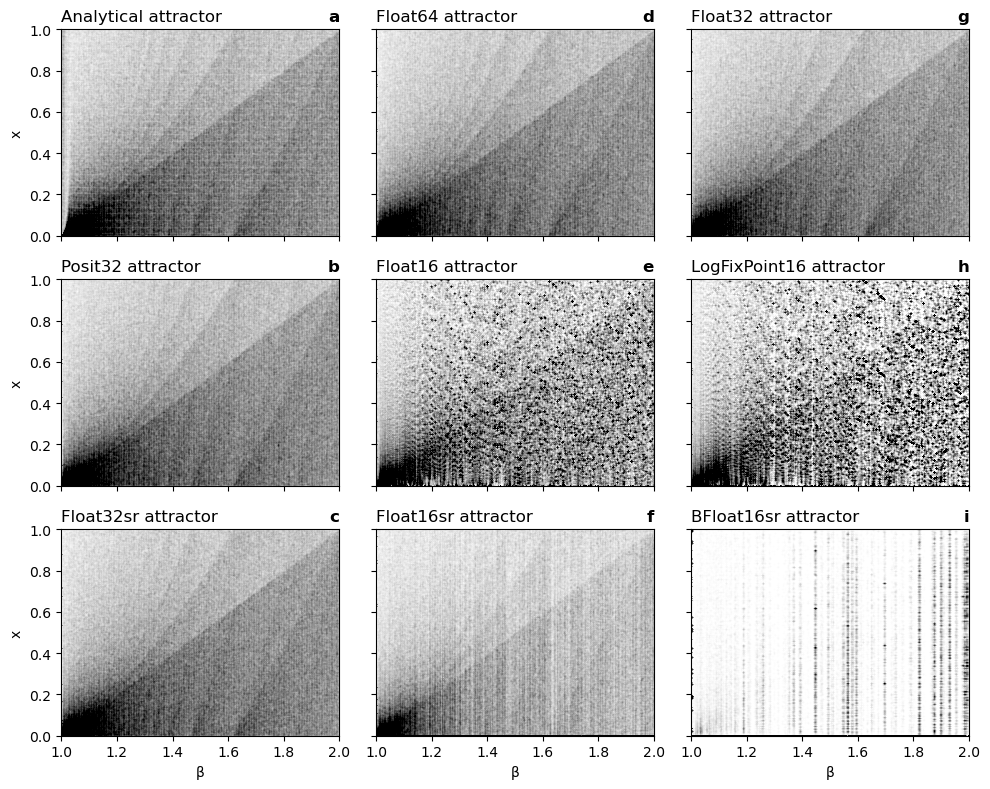

In [7]:
fig,axs = subplots(3,3,sharex=true,sharey=true,figsize=(10,8))

axs[1].scatter(ββ,xβsample,1,color="k",alpha=0.005)

for i in 1:8
    axs[i+1].scatter(ββ,xβFsample[i,:,:],1,color="k",alpha=0.005)
end

axs[3,1].set_xlabel("β")
axs[3,2].set_xlabel("β")
axs[3,3].set_xlabel("β")
axs[1,1].set_ylabel("x")
axs[2,1].set_ylabel("x")
axs[3,1].set_ylabel("x")
axs[1,1].set_xlim(extrema(βs2))
axs[1,1].set_ylim(0,1)

axs[1,1].set_title("Analytical attractor",loc="left")
axs[1,1].set_title("a",loc="right",fontweight="bold")
for i in 2:length(axs)
    axs[i].set_title("$(string(formats[i-1])) attractor",loc="left")
    axs[i].set_title(string(Char(96+i)),loc="right",fontweight="bold")
end
    
tight_layout()
# savefig("../plots/attractor.png")

**Fig. 5** Analytical attractor and as simulated with various number formats. (a) Analytical attractor sampled from Hofbauer's $h(x)$, (b-f) attractors obtained from simulation of the generalised Bernoulli map with various number formats: (b) Posit32, (c) Float32 + stochastic rounding, (d) Float64, (e) Float16, (f) Float16 + stochastic rounding, (g) Float32, (h) LogFixPoint16 and (i) BFloat16sr attractor.